In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (16, 9)
import sympy
import numpy as np
from fenics import *

import sympy2fenics as sf
from periodic_bc import FlatTorus3D
from time_stepping import leapfrog, theta_method

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
"""Chosen exact solution for testing."""
u_ = sf.str2sympy("(sin(z-t), sin(x-t), sin(y-t))")
# Initial data
a = Expression(sf.sympy2exp(u_), t=0.0, degree=3)
# Initial velocity
b = Expression(sf.sympy2exp(sympy.diff(u_, "t")), t=0.0, degree=3)
# Exact solution
u = lambda t: Expression(sf.sympy2exp(u_), t=t, degree=3)
# curl(u x curl(u)) for use later
g = lambda t: Expression(sf.sympy2exp(sf.curl(u_.cross(sf.curl(u_)))), t=t, degree=3)

In [3]:
"""Basic setup"""
# Domain
L = pi * 2.0
bc = FlatTorus3D(L, L, L)
# Mesh
N = 8
mesh = UnitCubeMesh(N, N, N)
coor = mesh.coordinates()
coor[:, :] = coor * L
mesh.bounding_box_tree().build(mesh)
# Function space
V = FunctionSpace(mesh, 'N1curl', 1, constrained_domain = bc)

In [4]:
"""
Maxwell wave equation: for divergence free a, b, and f, find u such that
    u'' + curl curl u = f,
    u(0) = a, u'(0) = b.
For our chosen exact solution, f=(0,0,0).
"""
# Right-hand side
f = lambda t: Expression(("0.0", "0.0", "0.0"), degree=2)
# Solve
ah = interpolate(a, V)
bh = interpolate(b, V)
v = TestFunction(V)
A = lambda u, v: dot(curl(u), curl(v))
fh = lambda t, v: dot(f(t), v)

In [5]:
# Crank-Nicolson solve
(ts, uh) = theta_method(A, fh, ah, bh, 0.5, 0.1, 200)

Progress: 0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..done


In [6]:
# Auxiliary functions
def proj_divfree(u):
    """Decompose a discrete vector field into the gradient and the div-free part."""
    # Solve the equation: -Δw=div(u)
    W = FunctionSpace(mesh, "CG", 1, constrained_domain = bc)
    w = TrialFunction(W)
    y = TestFunction(W)
    q = Function(W)
    problem = LinearVariationalProblem(dot(grad(w), grad(y)) * dx, dot(u, grad(y)) * dx, q)
    solver = LinearVariationalSolver(problem)
    solver.parameters["linear_solver"] = "minres"
    solver.parameters["preconditioner"] = "hypre_amg"
    solver.solve()
    # remove the gradient part
    g = project(grad(q), u.function_space())
    h = Function(u.function_space())
    h.vector()[:] = u.vector() - g.vector()
    return (h, g)

def eval_avg(u):
    """Compute the total integral of a vector field."""
    return np.array([assemble(u[i] * dx) for i in range(3)])

def l2_norm(u):
    """Compute the L2 norm of a Function."""
    return np.sqrt(assemble(dot(u, u) * dx))

def proj_imcurl(u):
    """Project a discrete vector field to its im(curl) part."""
    divfree = proj_divfree(u)[0]
    avg = eval_avg(divfree)
    return project(divfree - Constant(avg), u.function_space())

def plot_x_component_at_a_point(ts, uh, u, pt=(0.0, 0.0, 0.0), name="test"):
    """Plot the value of the x-component of the numerical and exact solution at one point."""
    peval = lambda u: u((pt))[0]
    up = []
    uhp = []
    for (i, t) in enumerate(ts):
        up.append(peval(u(t)))
        uhp.append(peval(uh[i]))
    plt.plot(ts, uhp, label="Numerical solution")
    plt.plot(ts, up, label="Exact solution")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("u(t, (0,0,0))")
    plt.savefig("{}.svg".format(name), transparent=True, bbox_inches='tight', pad_inches=0)
    
def plot_violation(ts, uh, name="test"):
    """Plot the magnitude of the average and the L2 norm of the gradient part of the numerical solution."""
    avgs = [np.linalg.norm(eval_avg(uh_)) for uh_ in uh]
    grads = [l2_norm(proj_divfree(uh_)[1]) for uh_ in uh]
    plt.plot(ts, avgs, label="Magnitude of the averge")
    plt.plot(ts, grads, label="$L^2$-norm of gradient part")
    plt.legend()
    plt.xlabel("Time")
    plt.savefig("{}.svg".format(name), transparent=True, bbox_inches='tight', pad_inches=0)

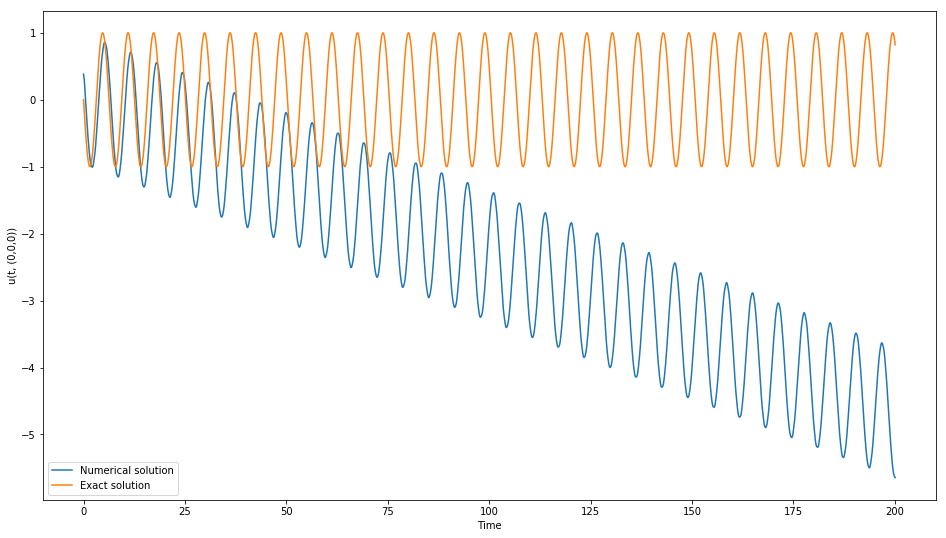

In [7]:
plot_x_component_at_a_point(ts, uh, u, name="linear_orig_sol")

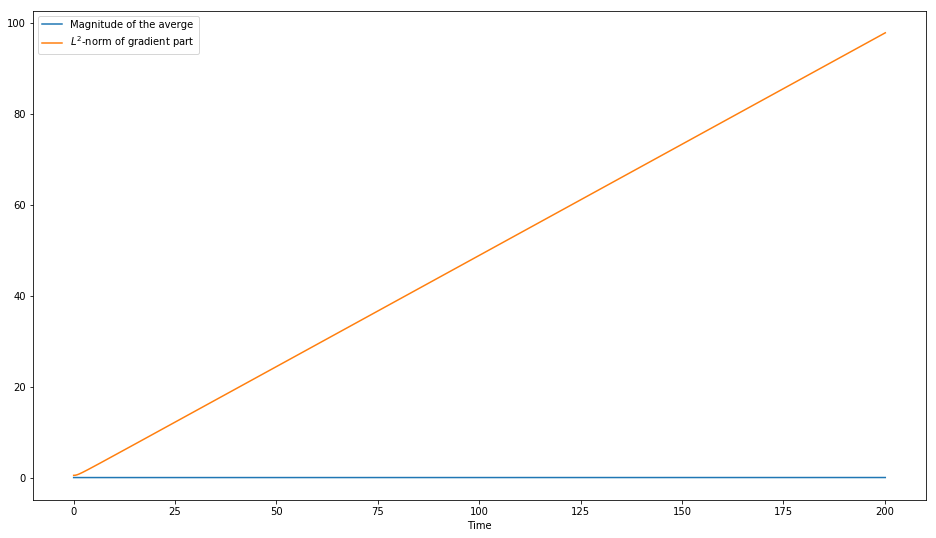

In [8]:
plot_violation(ts, uh, name="linear_orig_violation")

In [9]:
# Compute with initial data in the correct discrete space
ah0 = proj_imcurl(ah)
bh0 = proj_imcurl(bh)
# Crank-Nicolson solve
(ts, uh) = theta_method(A, fh, ah0, bh0, 0.5, 0.1, 200)

Progress: 0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..done


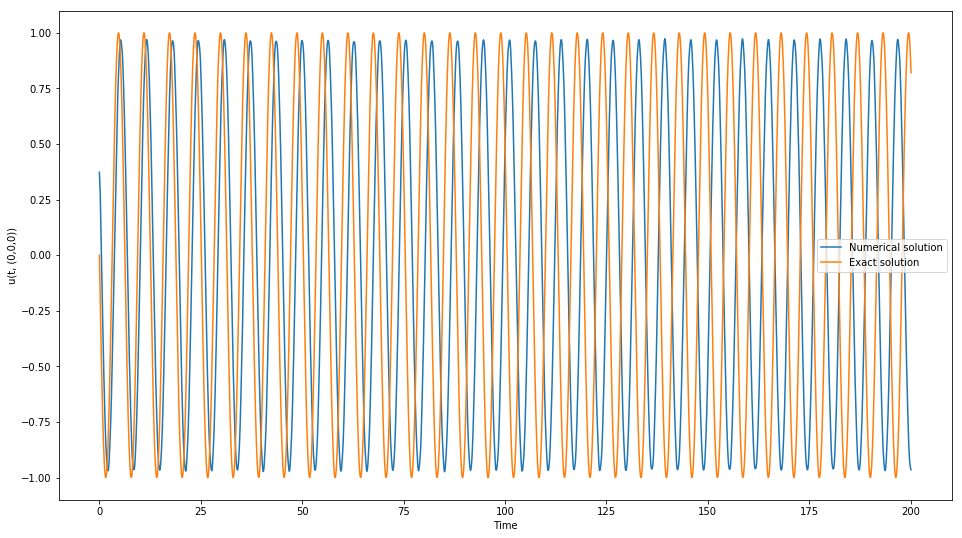

In [10]:
plot_x_component_at_a_point(ts, uh, u, name="linear_projected_sol")

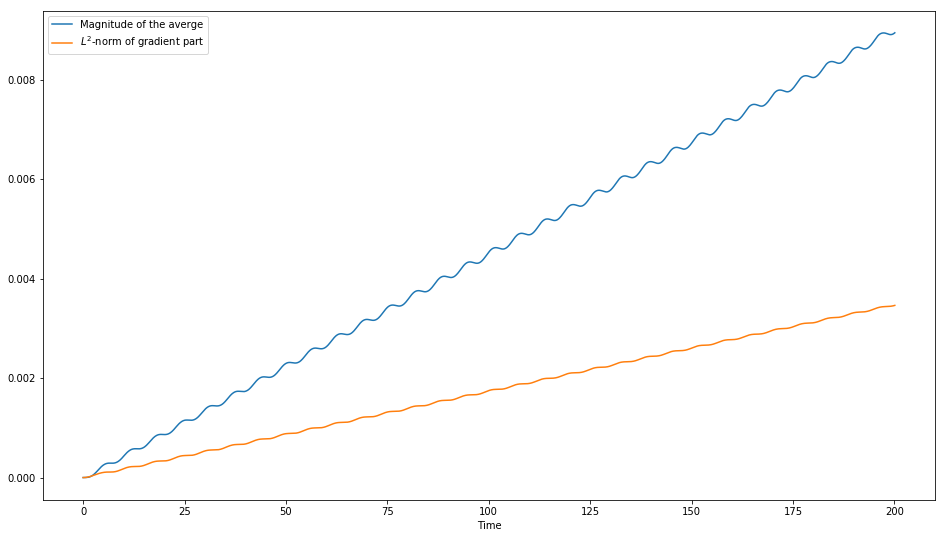

In [11]:
plot_violation(ts, uh, name="linear_projected_violation")

In [12]:
"""
Nonlinear problem:
    u'' + curl (1 + εu ×) curl u = f
This particular problem: u is the same as before but
    f = εu × curl u
"""
ε = 0.1
ah = interpolate(a, V)
bh = interpolate(b, V)
A = lambda u, v: dot(curl(u) + ε * cross(u, curl(u)), curl(v))
fh = lambda t, v: ε * dot(g(t), v)

In [13]:
# Crank-Nicolson solve
(ts, uh) = theta_method(A, fh, ah, bh, 0.5, 0.1, 200)

Progress: 0%..10%..20%..30%..blowup at t=71.30000000000022.


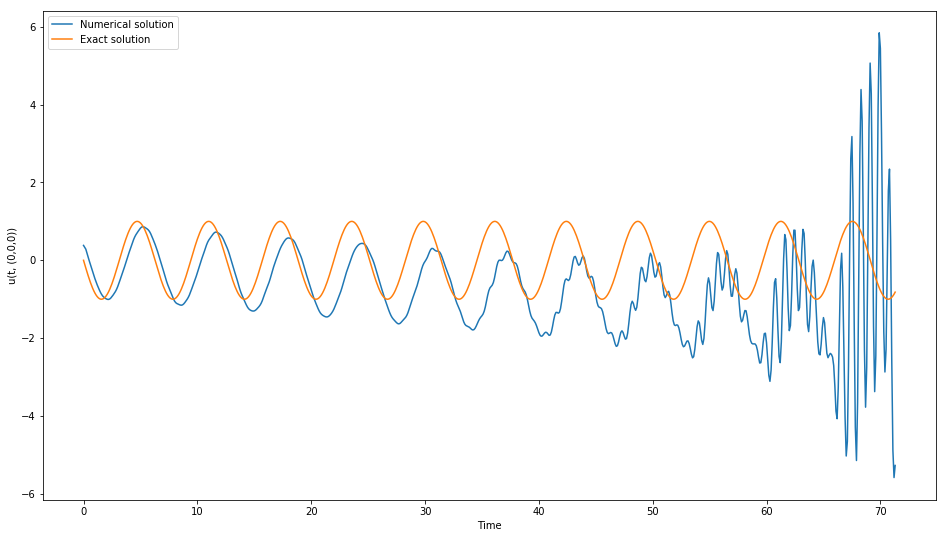

In [14]:
plot_x_component_at_a_point(ts, uh, u, name="nonlinear_orig_sol")

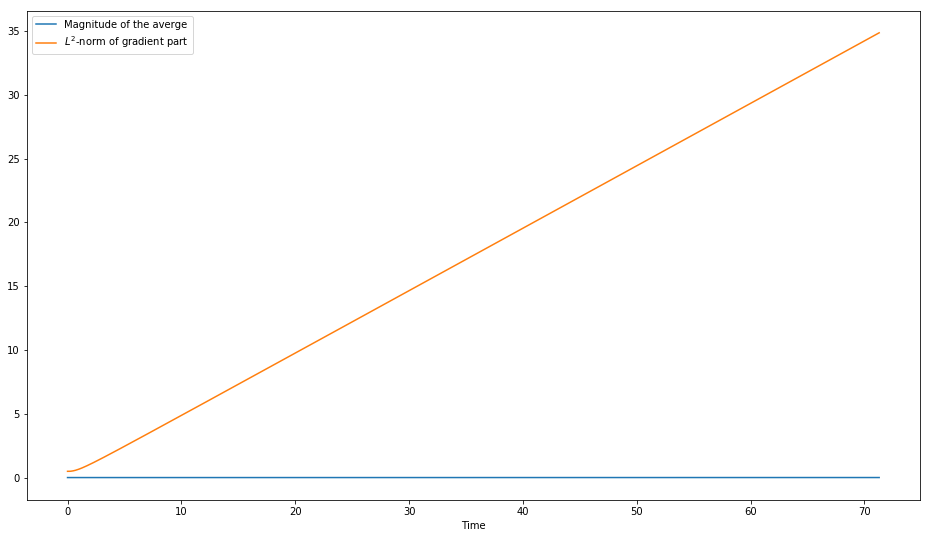

In [15]:
plot_violation(ts, uh, name="nonlinear_orig_violation")

In [16]:
# Compute with initial data in the correct discrete space
ah0 = proj_imcurl(ah)
bh0 = proj_imcurl(bh)
# Crank-Nicolson solve
(ts, uh) = theta_method(A, fh, ah0, bh0, 0.5, 0.1, 200)

Progress: 0%..10%..20%..30%..40%..50%..blowup at t=100.69999999999855.


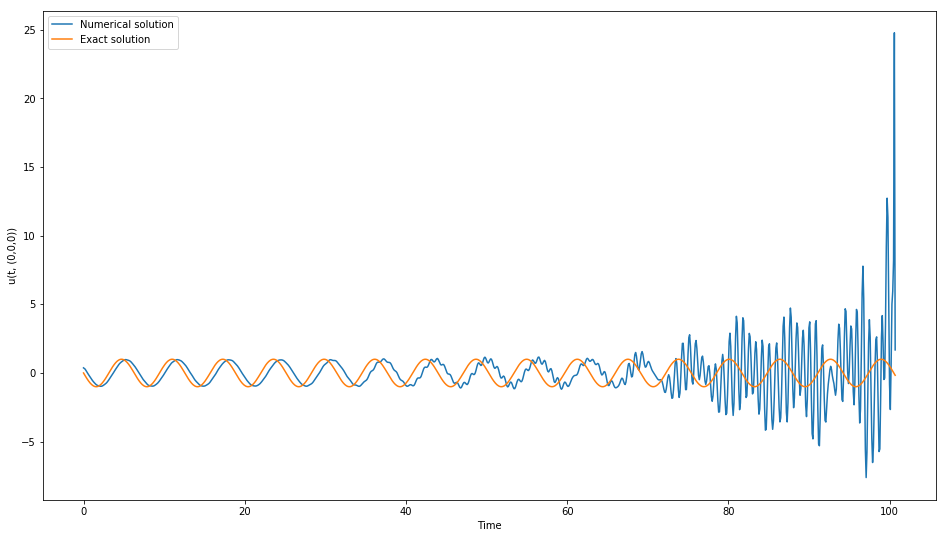

In [17]:
plot_x_component_at_a_point(ts, uh, u, name="nonlinear_projected_sol")

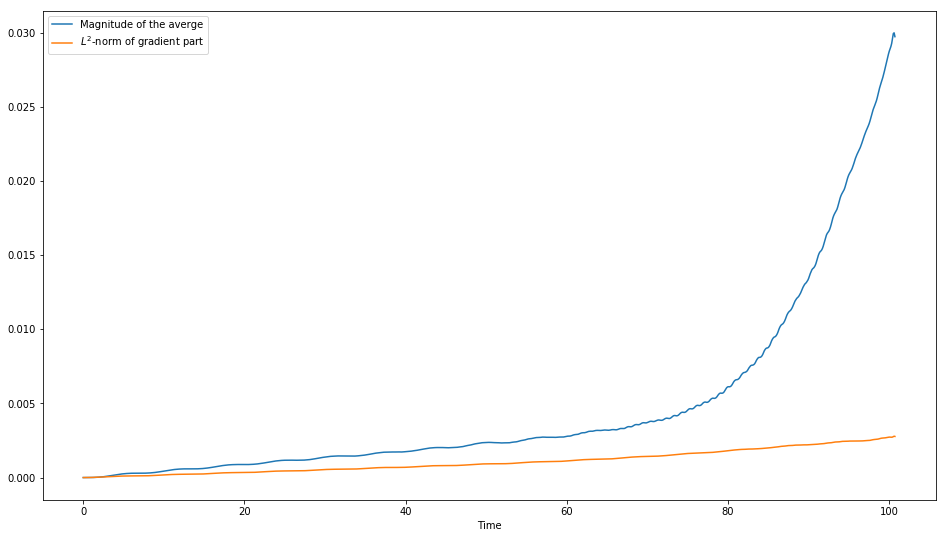

In [18]:
plot_violation(ts, uh, name="nonlinear_projected_violation")